# Apply PCI to simulated data 
## Investigate the impact of individual noise contributions

Here we apply PCI to data simulated via the LISA Simulation Suite, following the simulation scripts.

The simulated datasets are 3 days long. PCI is applied to 12 hours of data, with 4 hours of skipped data at the beginning of the simulation.

We need the following simulated datasets:
- full simulation noise dataset (including laser noise and secondary noises), with filename ending in `_measurements_4Hz.h5`
- secondary noises dataset, with filename ending in `_noise_sec_4Hz.h5`

# 0. Installations and data generation

The package dependencies are:

    pip install numpy scipy sympy h5py matplotlib xarray h5py scikit-learn
    pip install lisaconstants
    pip install lisainstrument
    pip install lisagwresponse
    pip install pytdi
    pip install backgrounds

and after installation, the data generation step is performed by running the simulation scripts: 

In [1]:
!pwd

/Users/ecastel2/Documents/virtual-envs/software-install/pcipy/notebooks


In [2]:
#!python ../simulation/noise_simulation.py /Users/ecastel2/Documents/research/GSFC/pci-inrep/simulations --tdi 2 --baseline --individual

In [3]:
#!python ../simulation/signal_simulation.py /Users/ecastel2/Documents/research/GSFC/pci-inrep/simulations --tdi 2

In [4]:
#!python ../simulation/all_sky_signal_simulation.py /Users/ecastel2/Documents/research/GSFC/pci-inrep/simulations --tdi 2

In [5]:
!ls -la /Users/ecastel2/Documents/research/GSFC/pci-inrep/simulations

total 21141808
drwxr-xr-x  22 ecastel2  staff        704 Mar 17 14:27 .
drwxr-xr-x  21 ecastel2  staff        672 Feb 20 16:03 ..
-rw-r--r--@  1 ecastel2  staff       6148 Mar 17 11:47 .DS_Store
-rw-r--r--   1 ecastel2  staff  945593288 Mar 14 11:13 2025-03-14_11h05_locking_n1_12_baseline_measurements_4Hz.h5
-rw-r--r--   1 ecastel2  staff  945588664 Mar 14 11:27 2025-03-14_11h05_locking_n1_12_baseline_noise_backlink_4Hz.h5
-rw-r--r--   1 ecastel2  staff  945588664 Mar 14 11:32 2025-03-14_11h05_locking_n1_12_baseline_noise_clock_4Hz.h5
-rw-r--r--   1 ecastel2  staff  945588664 Mar 14 11:21 2025-03-14_11h05_locking_n1_12_baseline_noise_laser_4Hz.h5
-rw-r--r--   1 ecastel2  staff  945588664 Mar 14 11:34 2025-03-14_11h05_locking_n1_12_baseline_noise_modulation_4Hz.h5
-rw-r--r--   1 ecastel2  staff  945592064 Mar 14 11:24 2025-03-14_11h05_locking_n1_12_baseline_noise_oms_4Hz.h5
-rw-r--r--   1 ecastel2  staff  945588664 Mar 14 11:26 2025-03-14_11h05_locking_n1_12_baseline_noise_ranging_4Hz.h

## 0.1 Settings and imports
Importing the relevant packages for the notebook. Setting up work directories.

In [6]:
import h5py
import os
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal

from datetime import datetime


from pytdi import Data
from pytdi.intervar import ETA_SET

from pcipy import plotting, pci_filter, channel_analysis 


/Users/ecastel2/Documents/virtual-envs/miniconda/envs/spyder-env/lib/python3.12/site-packages/PCIpy-0.0.1-py3.12.egg/pcipy/pci_filter.py:358: SyntaxWarning: invalid escape sequence '\s'
/Users/ecastel2/Documents/virtual-envs/miniconda/envs/spyder-env/lib/python3.12/site-packages/PCIpy-0.0.1-py3.12.egg/pcipy/pci_filter.py:358: SyntaxWarning: invalid escape sequence '\s'


In [7]:
workdir = "/Users/ecastel2/Documents/research/GSFC/pci-inrep/simulations/"
datadir = '/Users/ecastel2/Documents/research/GSFC/simulation-tests/orbits/'

measpath = '_measurements_4Hz.h5'
secondpath = '_noise_sec_4Hz.h5'

orbits = datadir+"keplerian-orbits.h5"

In [8]:
substring = ['locking_n1_12_laser_tm_oms', 'all_sky_gw', 'point_gw']
sims = ["noise", "all_sky", "point_source"]
datasets = dict(zip(sims, substring))

matchfile={}
dtpath={}

for n,d in zip(substring,datasets):
    timestamp=[]
    matchfile[n] = [f for f in os.listdir(workdir) if n in f]
    for m in matchfile[n]:
        # pick latest date
        timestamp.append(datetime.strptime(m[:17], "%Y-%m-%d_%Hh%M_"))
        #print(n, timestamp[n])
        dtpath[d] = max(timestamp).strftime("%Y-%m-%d_%Hh%M_")
dtpath

{'noise': '2025-03-14_11h05_',
 'all_sky': '2025-03-14_11h35_',
 'point_source': '2025-03-17_14h26_'}

In [9]:
skip_hours=4
pci_hours=12

## 1. Build data vector of the six LISA single-link channels

To build the data vector of the six LISA single-link channels $\vec{y} = \left[y_{ij}\right]$, with $i,j=1,2,3$ and $i\neq j$ we resort to the intermediary TDI variables $\eta$, implemented within `pytdi` as `ETA_SET`.


We build the single link $\vec{y}$ data vector for the full noise simulation and for the secondary noises, ending up with two single link vectors:
- full simulation single link vector $\vec{y}^{\text{full}}$
- secondary noises single link vector $\vec{y}^{\text{sec}}$

In [10]:
def build_data_vector(data_noise, skip=300, dtype=np.float64):
    central_freq = 281600000000000.0
    # Conventions 1, 2, 3, 1p, 2p, 3p
    delays_order = ['23', '31', '12', '32', '13', '21']
    mosas_order = ['12', '23', '31', '13', '21', '32']
    # Form intermediary variables for full data
    ETA_data_set = {key: ETA_SET[key].build(**data_noise.args) for key in ETA_SET.keys()}
    eta_noise_set = {key: ETA_data_set[key](data_noise.measurements) for key in ETA_data_set.keys()}
    # Form the measurement vector for moving arms containing all noises
    y = np.array([eta_noise_set[f'eta_{mosa}'] / central_freq for mosa in mosas_order], dtype=dtype).T
    y_full = y[skip:, :]
    del y

    return y_full

In [11]:
# Get noise simulation measurements
simpath = workdir + dtpath['noise'] + datasets['noise'] + measpath
print(simpath)
# load hdf5 file to read data attrs
sim = h5py.File(simpath, 'r')
# load data
data_noise = Data.from_instrument(simpath)

central_freq = sim.attrs['central_freq']
dt = sim.attrs['dt']
n_data = sim.attrs['size']

fs = data_noise.fs

skip = int(skip_hours * 3600 * fs)  #We skip the earliest part of the sim which is not representative

y_full = build_data_vector(data_noise, skip=skip, dtype=np.float64)

You are using a measurement file in a version that might not be fully supported


/Users/ecastel2/Documents/research/GSFC/pci-inrep/simulations/2025-03-14_11h05_locking_n1_12_laser_tm_oms_measurements_4Hz.h5


In [12]:
# Get secondary noises
secpath = workdir + dtpath['noise']+ datasets['noise'] + secondpath
print(secpath)

data_sec = Data.from_instrument(secpath)
    
y_sec = build_data_vector(data_sec, skip=skip, dtype=np.float64)

You are using a measurement file in a version that might not be fully supported


/Users/ecastel2/Documents/research/GSFC/pci-inrep/simulations/2025-03-14_11h05_locking_n1_12_laser_tm_oms_noise_sec_4Hz.h5


### 1.2 Data quicklook

Check the stencil size and take a look at the generated $y$s.

In [13]:
# TDI2 fractional delay Lagrange interpolating polynomials are of order 31=1+15*2
# Overall TDI delays are up to 8x single link delay = 8.34 s * 4 Hz * 8 = about 267 sample
# Add 15 on each end: 267 + 2*15 = 297   
# TDI2 overall stencil is then about 297 samples
# aPCI overall stencil width is 1 + nhalf*2
nhalf = 45
#ns = int(12 * 3600 * fs) # Use 12 hours data
ns = int(pci_hours * 3600 * fs) # For testing
window = np.ones(ns)

zsh:1: command not found: free


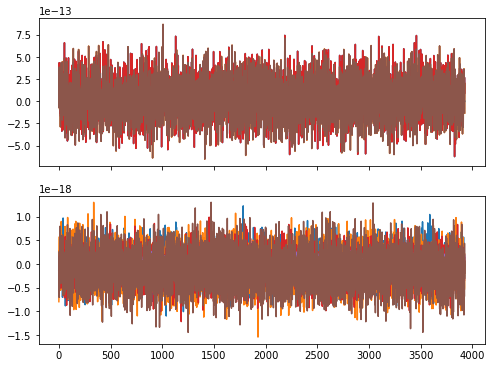

In [14]:
# Check time series
maxshow=4000
ev=ns//maxshow+1
_, axes = plt.subplots(2, 1, figsize=(8, 6), sharex = True)
for ich in range(len(y_full.T)):
    axes[0].plot(y_full[skip:skip+ns:ev, ich])
for ich in range(len(y_sec.T)):
    axes[1].plot(y_sec[skip:skip+ns:ev, ich])
!free

## 2. Apply PCI to the data

We now resort to {class}`PCIFilter` to evaluate PCI from $\vec{y}$.

An instance of {class}`PCIFilter` has two required inputs:
- `ydata`: matrix with the single link LISA temporal phase data streams $\vec{y}$ of length `ns`.
- `fs`: sampling rate of the data streams (Hz).

The optional parameters are
- `nhalf`: filter stencil halfwidth in samples. The default is 45.
- `order`: order of PCI. The default is 1.
- `maxcompts`: PCA results will be truncated to this length after initial processing. The default is 10.
- `Tscale`: if dt is None, then dt defaults to Tscale/ns

The input channels $\vec{y}$ are stretches of data, usually of length `ns+2*nhalf`, but sometimes varying. The variations are:
  - `:` (full length of matrix)
  - `0:ns_fixed`
  - `0:ns+2*nhalf`
  - `skip:skip+ns+2*nhalf`
  
In every case the window is trivial `np.ones([data lenght])`

The {py:class}`PCIFilter` class applies the following methods in order:

1. {py:meth}`pcipy.PCIFilter.build_data_matrix`
Pre-process $\vec{y}$ data `ydata` to build a matrix of shifted time-series. 

Output is a matrix $\vec{X}$ of size with size `ns` x `(2*nhalf+1)*nc` [what's `nc`?], where 

2. {py:meth}`pcipy.PCIFilter.apply_pca`

3. {py:meth}`pcipy.PCIFilter.set_stencil`

In [15]:
# import importlib
Tscale=10
# importlib.reload(pci_filter)
#pca_list = [apci_data(y_full[0:ns+2*nhalf, :].T,fs=fs, nhalf=nhalf, order=q, maxcompts=10, t0=0) ##2024-10-31:This most resembles the older results in apci_2.0_varying , particularly in the lowest variance endpoint,though with different data
pca_list = [pci_filter.PCIFilter(y_full[:ns+2*nhalf, :].T,
                                 fs=fs, nhalf=nhalf, 
                                 order=q, 
                                 maxcompts=10, 
                                 sort_by_rms=False,
                                 Tscale=Tscale)            
            for q in range(3)]

#c5demand8 mem peak 77%   ???
#              total        used        free      shared  buff/cache   available
#Mem:       15911316     1540616    13584348        1276      786352    14088684

!free


(172800, 546)
variance check rms: 3.6293758477819157e-09
shapes of chans, cov, components: (10, 172800) (10, 10) (10, 546)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
channel covariance diagonality test on 10 components: 6.384884245827209e-10
component diagonality test on 10 components: 7.93268343207981e-16
(172800, 1092)
variance check rms: 1.6408719853887923e-08
shapes of chans, cov, components: (10, 172800) (10, 10) (10, 1092)
[1.         1.         1.         1.00000001 1.         1.
 1.         1.         1.         1.        ]
channel covariance diagonality test on 10 components: 2.6631696701055635e-09
component diagonality test on 10 components: 1.2629532083925984e-15
(172800, 1638)
variance check rms: 5.8745295684337247e-08
shapes of chans, cov, components: (10, 172800) (10, 10) (10, 1638)
[1.         0.99999999 1.00000001 1.00000001 1.         1.00000001
 1.00000003 1.         1.00000002 1.00000001]
channel covariance diagonality test on 10 components: 9.505418198979685e-09
component diag

In [16]:
#pca_list = [apci_data(y_full[0:ns+2*nhalf, :].T,fs=fs, nhalf=nhalf, order=q, maxcompts=10, t0=0) ##2024-10-31:This most resembles the older results in apci_2.0_varying , particularly in the lowest variance endpoint,though with different data
pca_list_rs = [pci_filter.PCIFilter(y_full[:ns+2*nhalf, :].T,
                                    fs=fs, nhalf=nhalf, 
                                    order=q, 
                                    maxcompts=10, 
                                    sort_by_rms=True,
                                    Tscale=Tscale)            
            for q in range(3)]

#c5demand8 mem peak 77%   ???
#              total        used        free      shared  buff/cache   available
#Mem:       15911316     1540616    13584348        1276      786352    14088684

!free


(172800, 546)
variance check rms: 3.6293758477819157e-09
shapes of chans, cov, components: (10, 172800) (10, 10) (10, 546)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
channel covariance diagonality test on 10 components: 6.384884245827208e-10
component diagonality test on 10 components: 7.93268343207981e-16
(172800, 1092)
variance check rms: 1.6408719853887923e-08
shapes of chans, cov, components: (10, 172800) (10, 10) (10, 1092)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
channel covariance diagonality test on 10 components: 2.5731528858977096e-09
component diagonality test on 10 components: 1.144425753291593e-15
(172800, 1638)
variance check rms: 5.8745295684337247e-08
shapes of chans, cov, components: (10, 172800) (10, 10) (10, 1638)
[1.00000001 1.         1.00000001 0.99999999 1.         1.00000002
 0.99999999 1.         1.00000001 1.00000001]
channel covariance diagonality test on 10 components: 1.2102612232496434e-08
component diagonality test on 10 components: 1.5056412058060065e-15
zsh:1: command not 

In [17]:
pca_list_zm = [pci_filter.PCIFilter(y_full[:ns+2*nhalf, :].T,
                                    fs=fs, 
                                    nhalf=nhalf, 
                                    order=q, 
                                    maxcompts=10, 
                                    zero_mean=True, 
                                    Tscale=Tscale)            
            for q in range(3)]

ys (6, 172890)
means [2.93370417e-14 1.46131137e-14 1.56694887e-20 2.93357389e-14
 6.43274945e-21 1.46143978e-14]
new means [ 1.48765962e-29 -2.04646644e-30 -5.81042894e-36  4.61623023e-30
  1.48602611e-36 -9.99871730e-31]
(172800, 546)
variance check rms: 4.234392955537933e-09
shapes of chans, cov, components: (10, 172800) (10, 10) (10, 546)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
channel covariance diagonality test on 10 components: 4.2441352295797295e-10
component diagonality test on 10 components: 6.726710541717171e-16
ys (6, 172890)
means [2.93370417e-14 1.46131137e-14 1.56694887e-20 2.93357389e-14
 6.43274945e-21 1.46143978e-14]
new means [ 1.48765962e-29 -2.04646644e-30 -5.81042894e-36  4.61623023e-30
  1.48602611e-36 -9.99871730e-31]
(172800, 1092)
variance check rms: 1.560464523201154e-08
shapes of chans, cov, components: (10, 172800) (10, 10) (10, 1092)
[1.         1.         1.         1.         1.00000001 1.
 1.         1.         1.         1.        ]
channel covariance diagonal

### 2.1 plot PCI decomposition

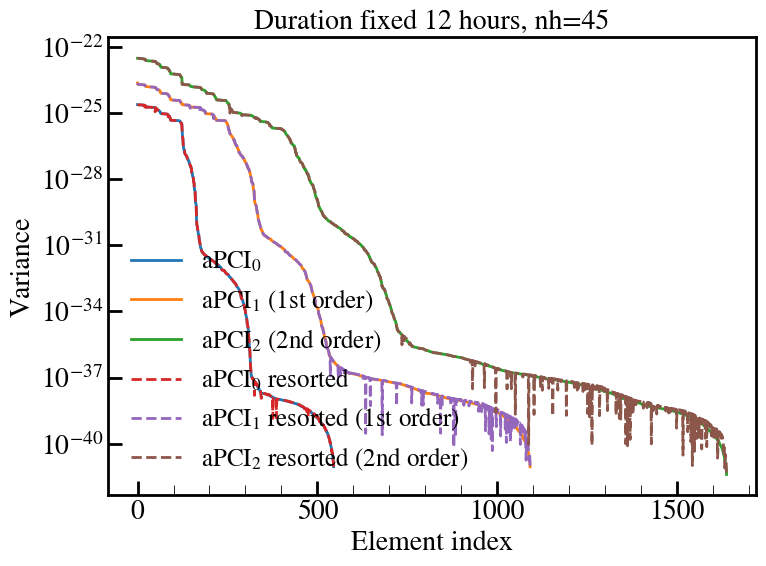

zsh:1: command not found: free


In [18]:
plotting.plotconfig(lbsize=20, lgsize=16, fsize=18, 
                    ticklabelsize=20, style='publication',
                    fontfamily = 'STIXGeneral')

fig1, ax1 = plt.subplots(nrows=1)

ax1.plot(pca_list[0].explained_variance, 
            #linestyle='dashed',
            label=r'aPCI$_0$',
            linewidth=2,
            rasterized=False)

ax1.plot(pca_list[1].explained_variance, 
            #linestyle='dashed',
            label=r'aPCI$_1$ (1st order)',
            linewidth=2,
            rasterized=False)

ax1.plot(pca_list[2].explained_variance,
            #linestyle='dashed',
            label=r'aPCI$_2$ (2nd order)',
            linewidth=2,
            rasterized=False)

if True:
    ax1.plot(pca_list_rs[0].explained_variance, 
                linestyle='dashed',
                label=r'aPCI$_0$ resorted',
                linewidth=2,
                rasterized=False)

    ax1.plot(pca_list_rs[1].explained_variance, 
                linestyle='dashed',
                label=r'aPCI$_1$ resorted (1st order)',
                linewidth=2,
                rasterized=False)

    ax1.plot(pca_list_rs[2].explained_variance,
                linestyle='dashed',
                label=r'aPCI$_2$ resorted (2nd order)',
                linewidth=2,
                rasterized=False)

if False:
    ax1.plot(pca_list_zm[0].explained_variance, 
                linestyle='dotted',
                label=r'aPCI$_0$ zm',
                linewidth=2,
                rasterized=False)

    ax1.plot(pca_list_zm[1].explained_variance, 
                linestyle='dotted',
                label=r'aPCI$_1$ zm (1st order)',
                linewidth=2,
                rasterized=False)

    ax1.plot(pca_list_zm[2].explained_variance,
                linestyle='dotted',
                label=r'aPCI$_2$ zm (2nd order)',
                linewidth=2,
                rasterized=False)

ax1.set_xscale('linear')
ax1.set_yscale('log')
ax1.set_xlabel(r"Element index", fontsize=20)
ax1.set_ylabel("Variance", fontsize=20)
# ax1.set_ylim([1e-42, 1e-25])
ax1.minorticks_on()
plt.legend(loc='lower left', frameon=False)
plt.title("Duration fixed "+str(int(ns/fs/3600))+ " hours, nh=" + str(nhalf))
plt.show()
!free
#for i in range(3):
#    print(pca_list[i].explained_variance-pca_list_zm[i].explained_variance)

## 3. Run channel analysis on the PCI output

i= 0
mean: 1.901616896601405e-21
variance:  9.020534992083184e-42
mean: -2.296536014097604e-21
variance:  3.685644311398309e-41
mean: -6.1428843886165364e-21
variance:  1.707855241624514e-41
mean: -7.334904770937248e-21
variance:  2.0064248695364286e-41
i= 1
mean: 3.6360780691766604e-21
variance:  4.0462895045924575e-42
mean: -1.166874595851208e-21
variance:  1.6143043348222725e-41
mean: -2.76900635211707e-21
variance:  1.7932759024362982e-41
mean: -2.9858688164150325e-21
variance:  3.252489856477095e-41


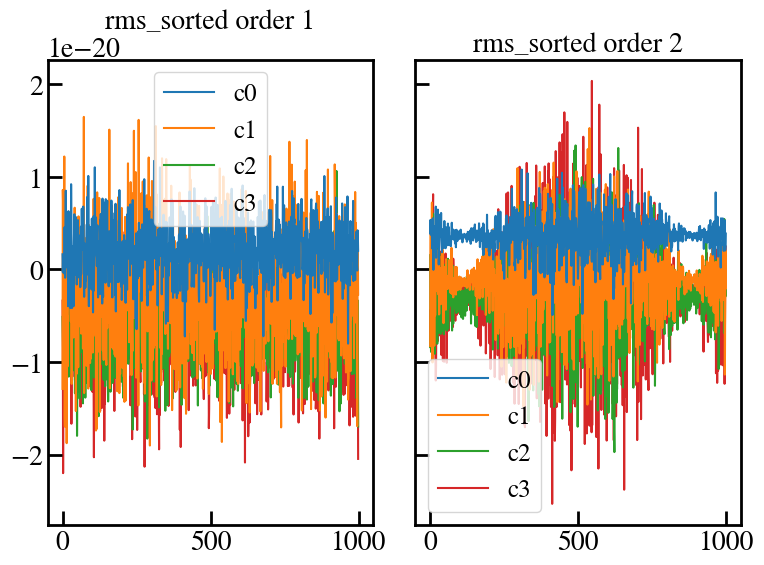

In [19]:
order=2
ev=100

filters=[pca_list_rs[order-1],pca_list_rs[order]]

sets=[np.array(xf.apply_for_channels(y_full[:ns+2*nhalf, :].T, n_channels=4,zero_mean=False,detrend=False)) for xf in filters]

channel_analysis.stationarity_plots(sets,title=['rms_sorted order '+str(order-1),'rms_sorted order '+str(order)])

i= 0
plotting 6 of 6 channels
subtracting bin means!
shape of input,trimmed,binned (6, 172800) (6, 172000) (6, 172, 1000)
172 batches of size 1000
i= 1
plotting 6 of 6 channels
subtracting bin means!
shape of input,trimmed,binned (6, 172800) (6, 172000) (6, 172, 1000)
172 batches of size 1000


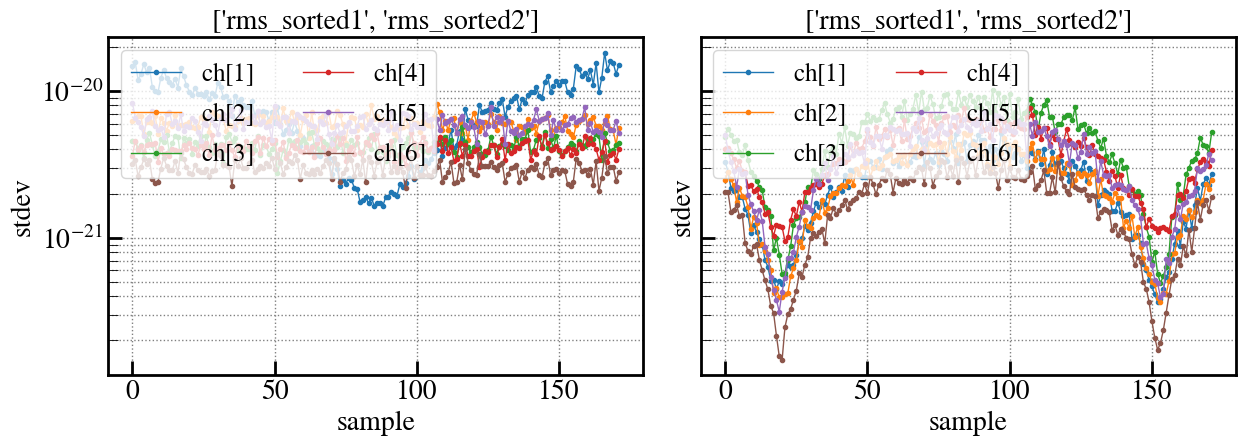

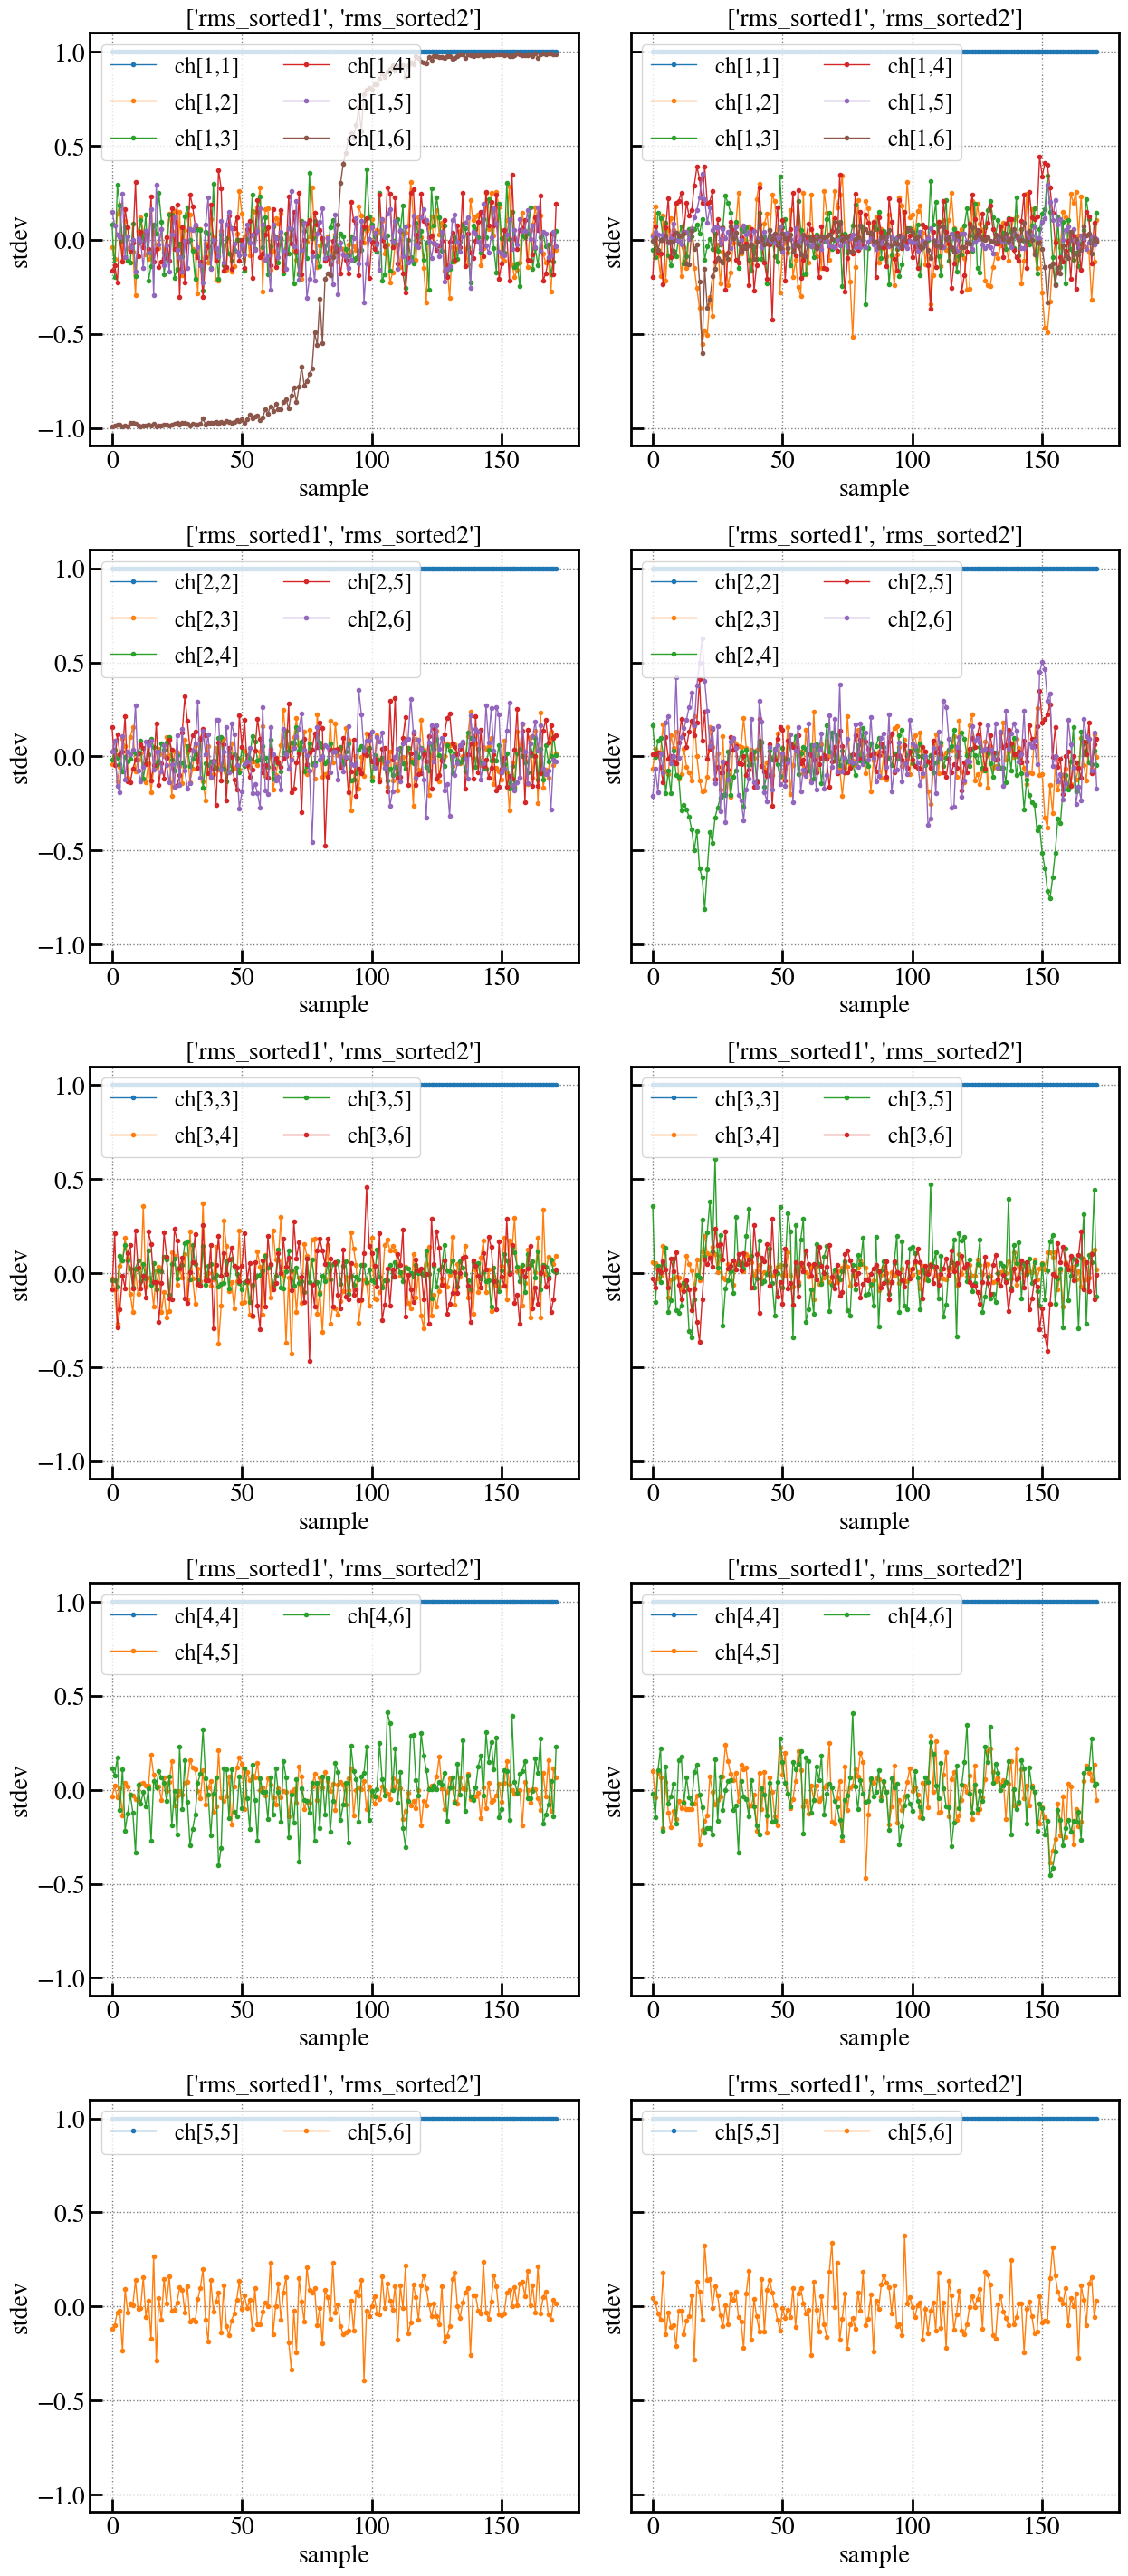

In [20]:
order=2
ev=100
#x=np.array(pca_list[order].apply_for_channels_split_orders(y_full[:ns+2*nhalf, :].T, n_channels=1))
#channel_analysis.stationarity_plots([pca_list[order],pca_list_zm[order],pca_list_rs[order]],y_full[:ns+2*nhalf, :].T,nchan=4,title=['standard','zero_mean','rms_sorted'])
#channel_analysis.temporal_variance_corr_plots([pca_list_zm[order],pca_list_rs[order]],y_full[:ns+2*nhalf, :].T,nchan=3,title=['zero_mean','rms_sorted'])
#channel_analysis.pci_temporal_variance_corr_plots([pca_list_rs[order-1],pca_list_rs[order]],y_full[:ns+2*nhalf, :].T,nchan=6,title=['rms_sorted'+str(order-1),'rms_sorted'+str(order)])
filters=[pca_list_rs[order-1],pca_list_rs[order]]
sets=[np.array(xf.apply_for_channels(y_full[:ns+2*nhalf, :].T, n_channels=6,zero_mean=False,detrend=False)) for xf in filters]
channel_analysis.temporal_variance_corr_plots(sets,nchan=6,title=['rms_sorted'+str(order-1),'rms_sorted'+str(order)])

### 3.1 Frequency Domain analysis

In [21]:
def compute_welch_matrix(ydata, **kwargs):
    """
    Compute the welch estimated PSDs and CSDs of a multivariate time series.

    Parameters
    ----------
    ydata : ndarray
        array of time series, size n_samples x n_channels
    """

    fy, _ = signal.welch(ydata[:, 0], **kwargs)
    welch_mat = np.zeros((fy.shape[0], ydata.shape[1], ydata.shape[1]), dtype=np.complex128)

    for i in range(ydata.shape[1]):
        _, welch_mat[:, i, i] = signal.welch(ydata[:, i], **kwargs)

        for j in range(i+1, ydata.shape[1]):
            _, welch_mat[:, i, j] = signal.csd(ydata[:, i], ydata[:, j], **kwargs)
            welch_mat[:, j, i] = np.conjugate(welch_mat[:, i, j])

    return fy, welch_mat


In [22]:
nperseg = 2**16 #didn't work with some, too short data segment (6hr)?
nperseg = 2**14
kwargs = {"fs": fs,
          "window": 'blackman',
          "nperseg": nperseg,
          "detrend": 'constant',
          "return_onesided": True,
          "scaling": 'density'}
freqs, y_welch_mat = compute_welch_matrix(y_full, **kwargs)
freqs, y_sec_welch_mat = compute_welch_matrix(y_sec, **kwargs)

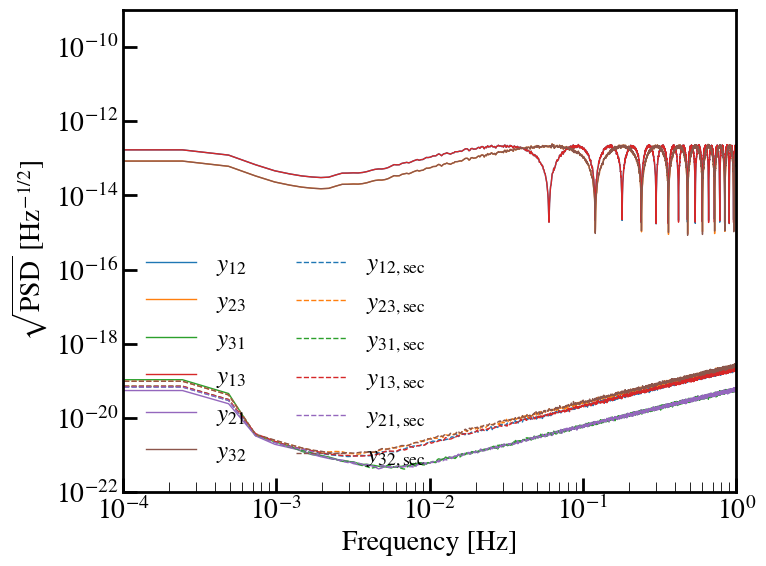

In [23]:
mosas_order = ['12', '23', '31', '13', '21', '32']

# Vizualize the single-link measurements in frequency domain
plotting.plotconfig(lbsize=20, lgsize=16, fsize=18, 
                    ticklabelsize=20, style='publication',
                    fontfamily = 'STIXGeneral')
fig, axes = plt.subplots(1, 1, figsize=(8, 6))

# For APCI
for i in range(6):
    axes.loglog(freqs, np.sqrt(y_welch_mat[:, i, i].real), 
                linewidth=1, 
                label=r'$y_{\mathrm{'+mosas_order[i]+'}}$',
                rasterized=True)
plt.gca().set_prop_cycle(None)
for i in range(6):
    axes.loglog(freqs, np.sqrt(y_sec_welch_mat[:, i, i].real), 
                linewidth=1,ls='--', 
                label=r'$y_{\mathrm{'+mosas_order[i]+',sec}}$',
                rasterized=True)
axes.legend(loc='lower left', ncol=2, frameon=False)
# axes.grid(linewidth=1, which='both', 
#           color='gray', 
#           linestyle='dotted')
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"$\mathrm{\sqrt{PSD}}$ [$\mathrm{Hz}^{-1/2}$]")
axes.set_xlim([1e-4, 1])
axes.set_ylim([1e-22, 1e-9])
# axes.set_title("Single-link periodograms")
fig.savefig("single-link-periodogram.pdf", format="pdf", dpi=300)
plt.show()

## 4. Reconstruct single-link channels

Computing single link
single link shape (6, 172800)
single link shape (6, 172800)
Computed single link
i= 0
mean: -1.9328697406359553e-23
variance:  4.890198925403017e-46
mean: 3.7833521590418484e-23
variance:  1.3113362111552122e-43
mean: -2.5847442693680697e-23
variance:  1.955751437802765e-45
mean: -1.4422248737360303e-22
variance:  1.5314383711236086e-43
mean: 1.928585093118067e-23
variance:  4.9346941885564116e-46
mean: 2.5847446787173726e-23
variance:  1.9557515319311566e-45
i= 1
mean: -6.000548853589138e-24
variance:  3.1720922956764386e-47
mean: 6.2376195703110515e-24
variance:  2.2676892517388593e-43
mean: -2.0925209659986244e-24
variance:  4.886206341857358e-47
mean: -7.255464180171782e-23
variance:  2.1207291911335216e-43
mean: 5.968894961992812e-24
variance:  3.527710810786004e-47
mean: 2.0925221296047957e-24
variance:  4.886208992974912e-47
i= 2
mean: -7.641070559984003e-20
variance:  1.4721443236534653e-37
mean: -8.97156217916586e-21
variance:  7.818169324633122e-39
mean:

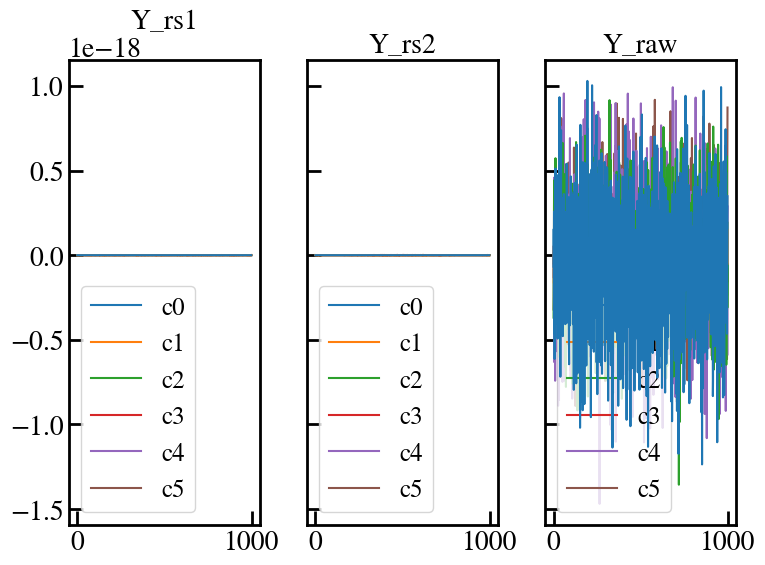

In [24]:
order=2
nchannels=10
ev=100
filters=[pca_list_rs[order-1],pca_list_rs[order]]
[xf.set_stencil(nchannels) for xf in filters]
sets=[np.array(xf.apply_for_channels(y_full[:ns+2*nhalf, :].T, n_channels=nchannels,zero_mean=False,detrend=False)) for xf in filters]
print("Computing single link")
Ysets=[xf.compute_single_links_from_channels(iset) for xf,iset in zip(filters,sets)]
titles=['Y_rs'+str(order-1),'Y_rs'+str(order)]
if True:
    Ysets+=[y_sec[nhalf:ns+nhalf, :].T]
    titles+=['Y_raw']
print("Computed single link")
channel_analysis.stationarity_plots(Ysets,title=titles)

i= 0
plotting 6 of 6 channels
subtracting bin means!
shape of input,trimmed,binned (6, 172800) (6, 172000) (6, 172, 1000)
172 batches of size 1000
i= 1
plotting 6 of 6 channels
subtracting bin means!
shape of input,trimmed,binned (6, 172800) (6, 172000) (6, 172, 1000)
172 batches of size 1000
i= 2
plotting 6 of 6 channels
subtracting bin means!
shape of input,trimmed,binned (6, 172800) (6, 172000) (6, 172, 1000)
172 batches of size 1000


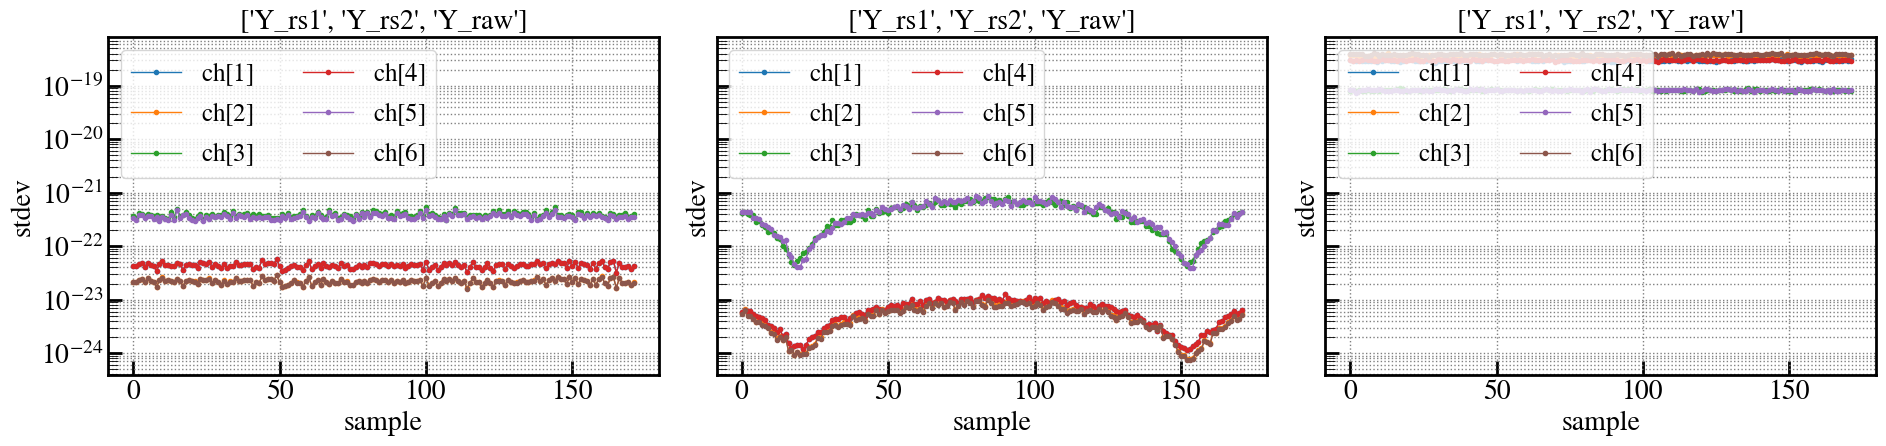

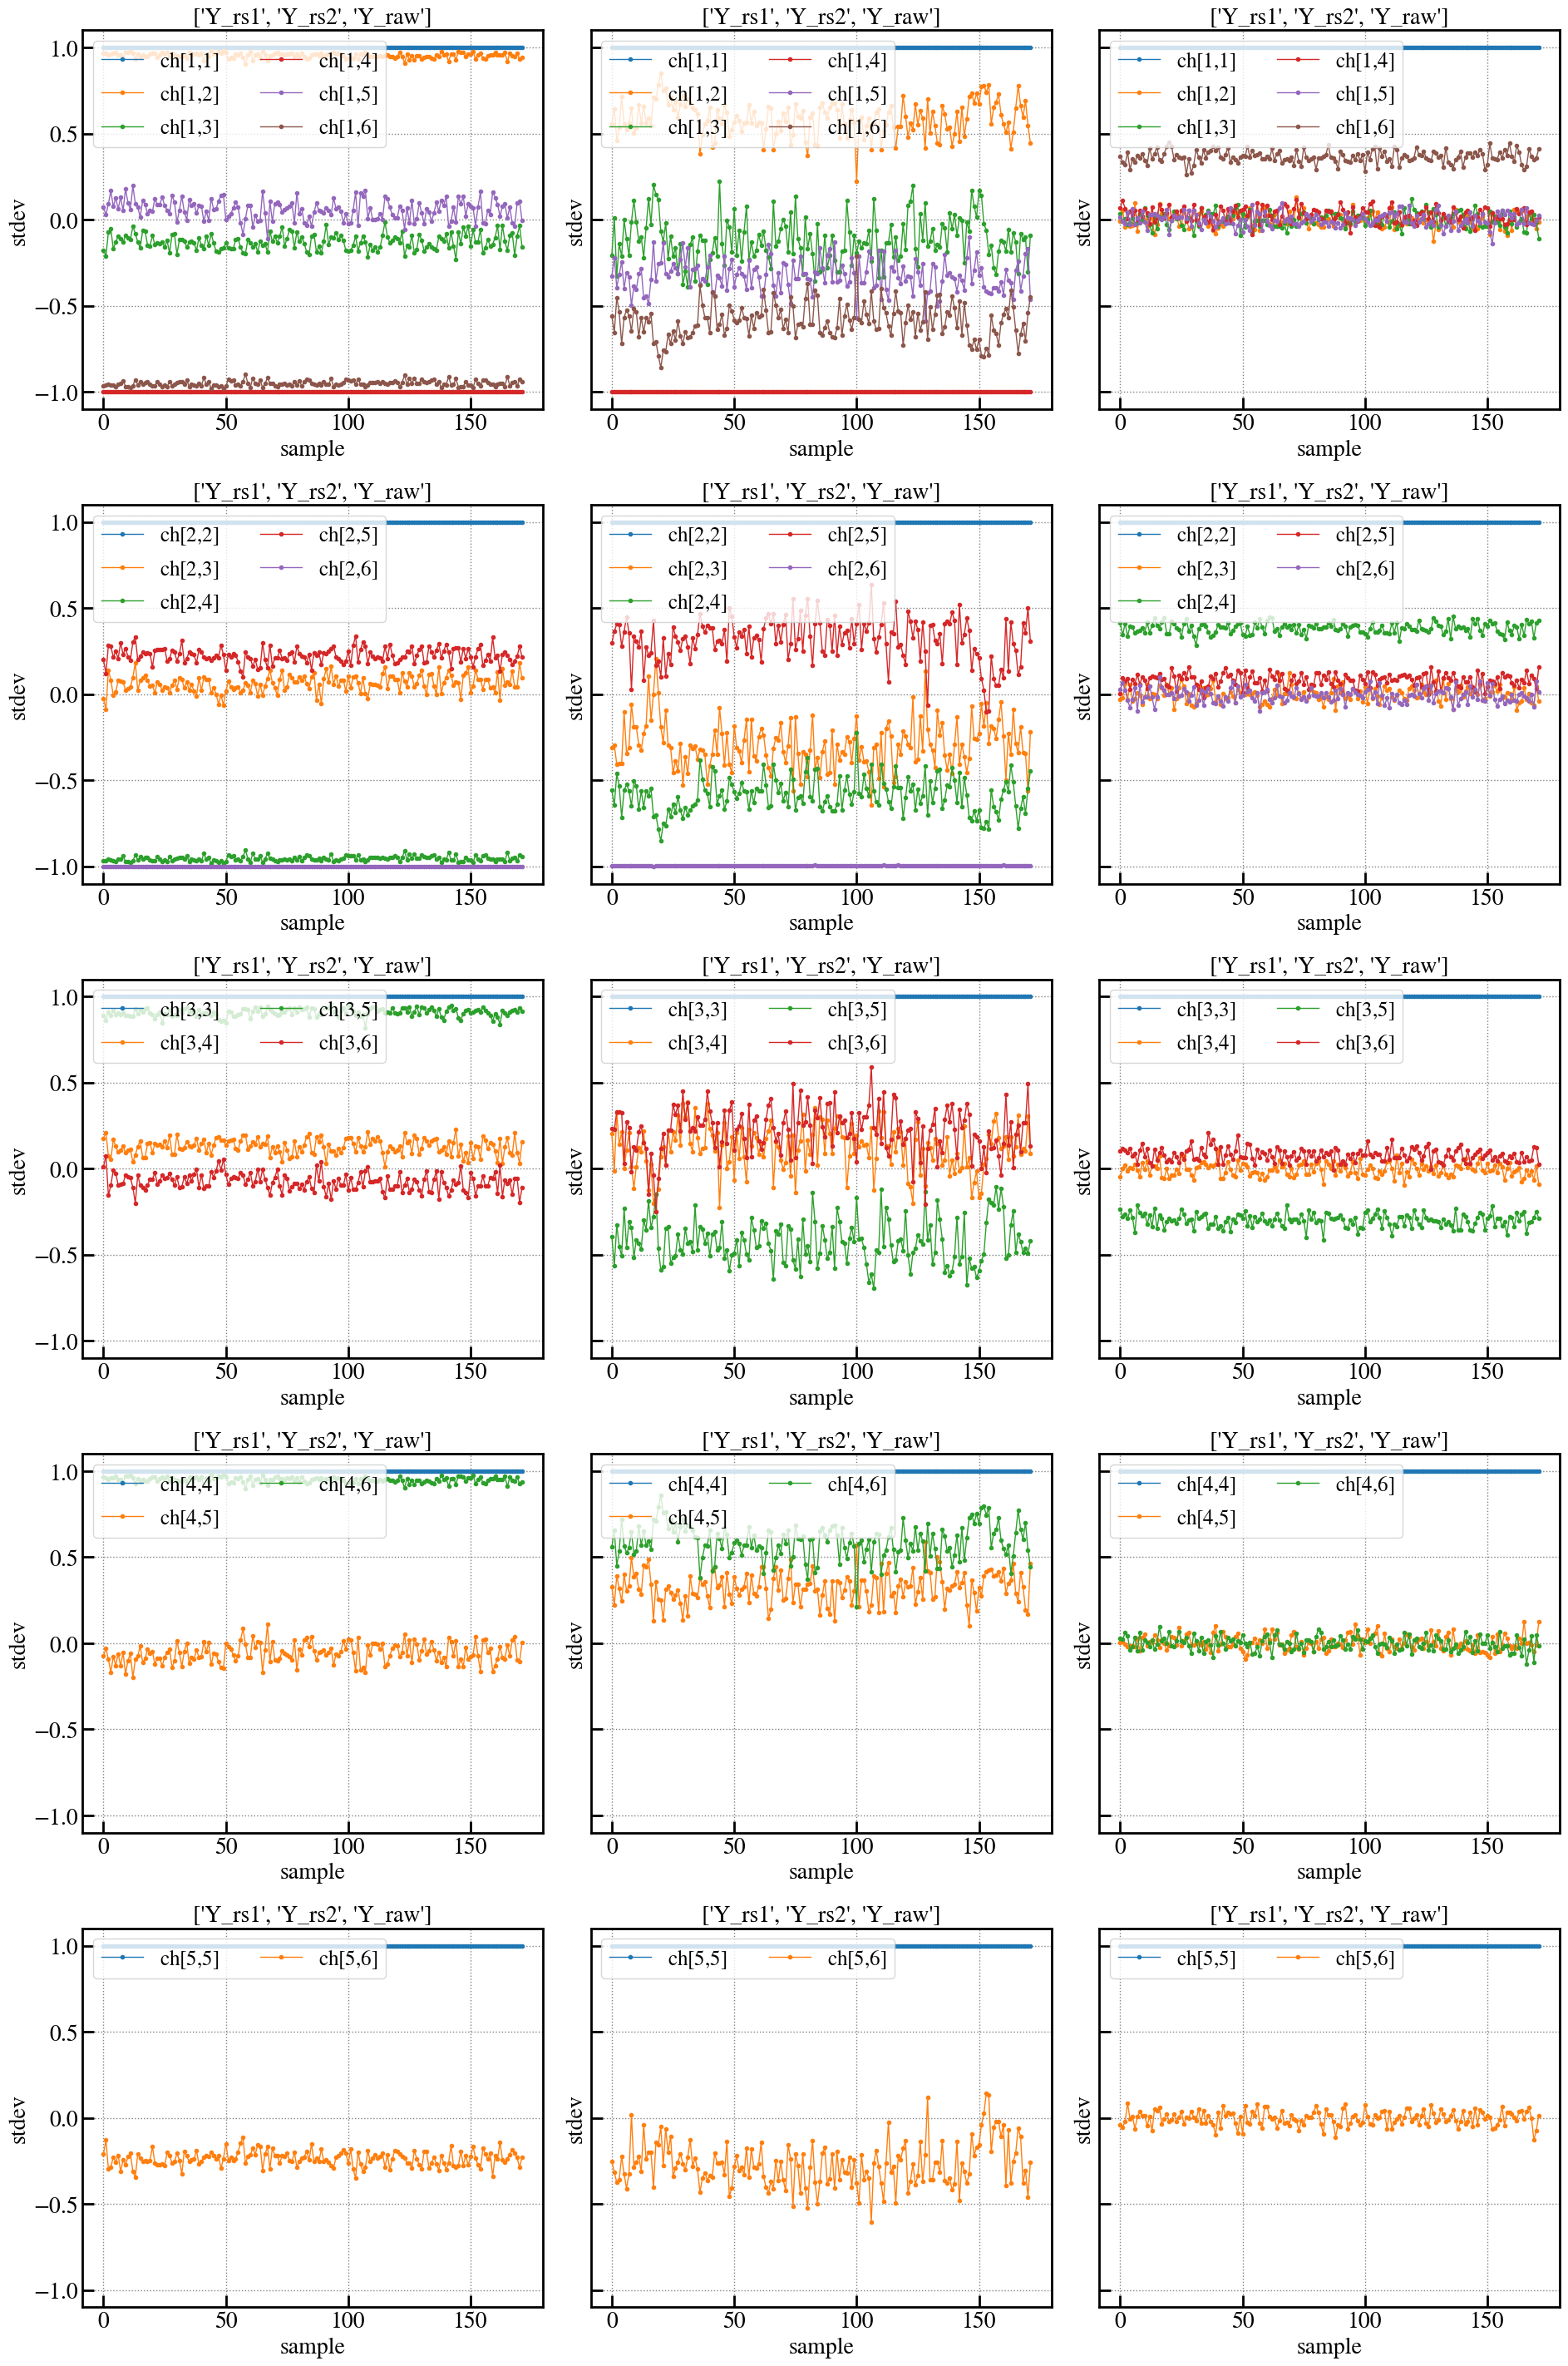

In [25]:
channel_analysis.temporal_variance_corr_plots(Ysets[:],nchan=6,title=titles)

In [26]:
freqs1, y_pci1_welch_mat = compute_welch_matrix(Ysets[0].T, **kwargs)
freqs2, y_pci2_welch_mat = compute_welch_matrix(Ysets[1].T, **kwargs)

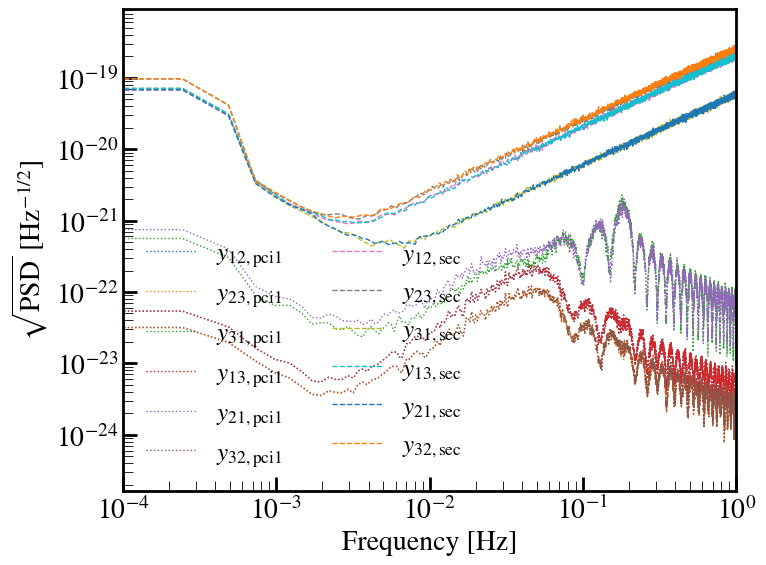

In [27]:
# Vizualize the single-link measurements in frequency domain
plotting.plotconfig(lbsize=20, lgsize=16, fsize=18, 
                    ticklabelsize=20, style='publication',
                    fontfamily = 'STIXGeneral')
fig, axes = plt.subplots(1, 1, figsize=(8, 6))

# For APCI
for i in range(6):
    axes.loglog(freqs, np.sqrt(y_pci1_welch_mat[:, i, i].real), 
                linewidth=1, ls=':',
                label=r'$y_{\mathrm{'+mosas_order[i]+',pci1}}$',
               rasterized=True)
#for i in range(6):
#    axes.loglog(freqs, np.sqrt(y_pci2_welch_mat[:, i, i].real), 
#                linewidth=1, 
#                label=r'$y_{\mathrm{'+mosas_order[i]+',pci2}}$',
#               rasterized=True)
for i in range(6):
    axes.loglog(freqs, np.sqrt(y_sec_welch_mat[:, i, i].real), 
                linewidth=1, ls='--',
                label=r'$y_{\mathrm{'+mosas_order[i]+',sec}}$',
                rasterized=True)
axes.legend(loc='lower left', ncol=2, frameon=False)
# axes.grid(linewidth=1, which='both', 
#           color='gray', 
#           linestyle='dotted')
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"$\mathrm{\sqrt{PSD}}$ [$\mathrm{Hz}^{-1/2}$]")
axes.set_xlim([1e-4, 1])
#axes.set_ylim([1e-25, 1e-9])
# axes.set_title("Single-link periodograms")
fig.savefig("single-link-periodogram.pdf", format="pdf", dpi=300)
plt.show()

Alertnative Y reconstruction

In [28]:
    def filter_single_link_data(self, ydata,n_channels=None):
        '''
        Compute recovered single-link channel vectors from a set of single-link data. This should yield 
        identical results to appropriately called compute_single_link_from_channels but we first implement
        separately for testing, since the stencil_compts stuff is new. This one is more low-level and 
        doesn't assum the stencil is selected.
        
        Parameters
        ----------
        ydata : ndarray 
            The raw single-link data-set to be transformed.

        Returns
        -------
        reconstructed_ydata : ndarray
            Reconstructed single link data channels
        '''
        if n_channels is None: n_channels=self.maxcompts
        y_transformer=self.components[-n_channels:,:6].T

        chans_data = self.apply_for_channels(ydata, n_channels)
        Z=np.dot(y_transformer,chans_data)
        print('single link data shape', Z.shape)
        return Z

In [29]:
Zsets=[np.array(xf.filter_single_link_data(y_full[:ns+2*nhalf, :].T, n_channels=nchannels)) for xf in filters]
print("Comparing single link")
diff=[Zsets[i]-Ysets[i] for i in range(order)]
print(diff)

single link data shape (6, 172800)
single link data shape (6, 172800)
Comparing single link
[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])]


## 5. Estimate sensitivity
### Computation of empirical response with welch periodograms
Based and empirical sensitivity calculation simulated signal over simulated noise as developed in initial-dev-from-pylisa

In [30]:
# Some options and prep for the welch_matrix calc
nperseg = 1e4
welch_kwargs = {"fs": fs,
          "window": 'blackman',
          "nperseg": nperseg,
          "detrend": 'constant',
          "return_onesided": True,
          "scaling": 'density'}

#and for the orthogonalization...
#multiple_dot = lambda a,b: np.einsum("ijk, ikl -> ijl", a, b)
def multiple_dot(a_mat, b_mat):
    """
    Perform the matrix multiplication of two list of matrices.

    Parameters
    ----------
    a : ndarray
        series of m x n matrices (array of size p x m x n)
    b : ndarray
        series of n x k matrices (array of size p x n x k)

    Returns
    -------
    c : ndarray
        array of size p x m x k containg the dot products of all matrices
        contained in a and b.


    """

    return np.einsum("ijk, ikl -> ijl", a_mat, b_mat)


In [31]:

def estimate_sensitivity(pci, data_n, data_gw, n_channels=6, joint=True, single_link=False, welch_kwargs=welch_kwargs):
    
    # PCI transformation vector, size n_channel x p
    #v_pci = pci.v_pci(n_channels)
    # Projection of the data segment t
    #print('compute noise channels')
    #print('for',n_channels,'channels')
    #print('components shape',pci.components.shape)
    if single_link:
        e_pci_n = pci.filter_single_link_data(data_n,n_channels).T
        e_pci_gw = pci.filter_single_link_data(data_gw,n_channels).T
    else:
        e_pci_n = pci.apply_for_channels(data_n,n_channels).T
        e_pci_gw = pci.apply_for_channels(data_gw,n_channels).T
    #print(e_pci_n.shape,e_pci_n.shape)
    #print('compute welch')
    # Welch spectrum matrix for PCI variables from noise
    freqs, e_pci_n_mat = compute_welch_matrix(e_pci_n, **welch_kwargs)
    print(freqs, e_pci_n_mat)
    # Welch spectrum matrix for PCI variables from noise
    freqs, e_pci_gw_mat = compute_welch_matrix(e_pci_gw, **welch_kwargs)
    print(freqs, e_pci_gw_mat)
    # Orthogonalization
    _, s, vh = np.linalg.svd(e_pci_n_mat)
    # Apply the orthogonal transformation to the GW signal    
    e_pci_gw_mat_ortho = multiple_dot(vh, multiple_dot(e_pci_gw_mat, np.swapaxes(vh, 1, 2).conj()))
    # Apply the orthogonal transformation to the noise covariance
    e_pci_n_mat_ortho = multiple_dot(vh, multiple_dot(e_pci_n_mat, np.swapaxes(vh, 1, 2).conj()))
    # Output sensitivity for each variable, size nfreqs x n_channels
    # pci_sens = np.array([np.abs(s[:, j] / e_pci_gw_mat_ortho[:, j, j]) for j in range(n_channels)]).T
    pci_sens = np.array([np.abs(e_pci_n_mat_ortho[:, j, j] / e_pci_gw_mat_ortho[:, j, j]) for j in range(n_channels)]).T
    
    print("Computation completed.")
    if joint:
        pci_sens = 1 / np.sum(1/np.array(pci_sens), axis=1)
    
    return freqs, pci_sens

def process_data(y_noise, y_gw, fs, nhalf, order=1, n_channels=6, pca_y_noise=None, joint=False, pci_kwargs={}, welch_kwargs={}):
    '''
    Apply PCI and compute sensitivity all wrapped up together. If pda_y_noise is provided it is used
    only for computing the PCI and y_noise is used only for the sensitivity application
    '''
    
    if pca_y_noise is None: pca_y_noise=y_noise
        
    print('nhalf:',nhalf, 'sens data_size:',len(y_noise),'pca data_size:',len(pca_y_noise))
    
    # Get the length of the time series
    data_size = y_noise.shape[0]
    # data_noise = Data.from_instrument(instr_data)

    print('compute PCI')
    pci=pci_filter.PCIFilter(y_noise, fs, maxcompts=10, nhalf=nhalf,order=order,**pci_kwargs)
    
    result=estimate_sensitivity(pci, y_noise, y_gw, n_channels=n_channels, joint=joint, welch_kwargs=welch_kwargs)
    del(pci)
    
    return result

#### We need to read matching GW simulations results for the empirical sensitivity calculation

In [32]:
gw_path = workdir+dtpath["point_source"]+datasets["point_source"]+measpath

data_gw = Data.from_gws(gw_path,orbits)

#gw_dataset='tps/y'
#hdf5 = h5py.File(gw_path, 'r')
#dset=hdf5[gw_dataset]

#measurements = {f'isi_{link}': dset[:,ilink] for ilink, link in enumerate(mosas_order)}
#hdf5.close()

y_list = [data_gw.measurements[f'isi_{link}'] for link in mosas_order]
y_gw = np.array(y_list, dtype=np.float64).T[skip:, :]


You are using a GW file in a version that might not be fully supported


#### For comparison, we also need the TDI data

In [33]:
#tdipath1 = workdir + dtpath + 'noise_tdi1_4Hz.h5'
tdipath2 = workdir +  dtpath['noise'] + datasets['noise'] + '_noise_tdi2_4Hz.h5'
# open hdf5 TDI file
#tdi1 = h5py.File(tdipath1, 'r')
tdi2 = h5py.File(tdipath2, 'r')

x2_noise = tdi2['x'][()] / central_freq
y2_noise = tdi2['y'][()] / central_freq
z2_noise = tdi2['z'][()] / central_freq

tdi2_gw_file = workdir+dtpath["point_source"]+datasets["point_source"]+"_tdi2_4Hz.h5"

hdf5 = h5py.File(tdi2_gw_file, 'r')
x2_gw = hdf5['x'][()]
y2_gw = hdf5['y'][()]
z2_gw = hdf5['z'][()]
hdf5.close()

# Compute welch matrix for the TDI 2.0 noise
e_tdi2_n = np.array([x2_noise[skip:skip+ns],
                     y2_noise[skip:skip+ns],
                     z2_noise[skip:skip+ns]] ).T
freqs, p_tdi2_n_mat = compute_welch_matrix(e_tdi2_n, **welch_kwargs)
# Compute the welch matrix for the TDI 2.0 GW signal
e_tdi2_gw = np.array([x2_gw[skip:skip+ns],
                      y2_gw[skip:skip+ns],
                      z2_gw[skip:skip+ns]]).T
freqs, p_tdi2_gw_mat = compute_welch_matrix(e_tdi2_gw, **welch_kwargs)

# Orthogonalization
u_tdi, s_tdi, vh_tdi = np.linalg.svd(p_tdi2_n_mat)

# Apply the orthogonal transformation to the GW signal
p_tdi2_gw_mat_ortho = multiple_dot(vh_tdi, 

multiple_dot(p_tdi2_gw_mat, np.swapaxes(vh_tdi, 1, 2).conj()))

# Empirical orthogonalization of TDI
mean_tdi2 = 1 / np.sum(
    np.array([np.abs(p_tdi2_gw_mat_ortho[:, j_tdi, j_tdi] / np.abs(s_tdi[:, j_tdi])) for j_tdi in range(3)]), axis=0)

#### PCI channel sensitivities

In [34]:
print(ns)
print(y_full[0:ns,:].T)
print(y_gw[0:ns,:].T)
display(welch_kwargs)

172800
[[-5.71430273e-13 -1.17694737e-13  2.81320547e-13 ...  8.03256102e-14
   1.48824651e-13  4.68594219e-13]
 [-3.74158615e-13  2.41180556e-13  7.52513402e-14 ...  1.59371307e-13
   1.59074206e-13  1.97184752e-13]
 [-2.22698421e-20 -6.92612572e-20  1.10899668e-19 ...  2.98957505e-20
  -5.20573358e-20  2.87780329e-20]
 [-5.71360355e-13 -1.17249594e-13  2.81118876e-13 ...  7.98454029e-14
   1.49856401e-13  4.67370862e-13]
 [-1.43033595e-20  1.60629186e-19 -2.91401972e-20 ... -4.47966930e-20
  -8.14678498e-20  7.21032059e-20]
 [-3.75623137e-13  2.39612950e-13  7.68130107e-14 ...  1.60399174e-13
   1.57293939e-13  1.99584092e-13]]
[[-3.93037248 -1.27626273  0.91789079 ...  1.36282489 -1.19103808
  -1.75526885]
 [-1.05614331 -0.33395539  0.08087629 ...  0.60061119 -0.19594804
   1.65035394]
 [ 0.08459325  0.07356997  0.17079385 ...  0.23151339  0.06903188
  -0.19505113]
 [ 4.3400399   1.08650949 -1.00789318 ... -1.19993681  2.04360327
   1.15433618]
 [-0.10462647 -0.02673597 -0.16853171 

{'fs': 4.0,
 'window': 'blackman',
 'nperseg': 10000.0,
 'detrend': 'constant',
 'return_onesided': True,
 'scaling': 'density'}

In [35]:
#Test as it appears in the initial-dev notebook
nh=45
pci_sens_list = [
#    ["PCI-0 std", process_data(y_full[:ns, :].T, y_gw[0:ns, :].T, kwargs['fs'], nh, order=0, n_channels=6, joint=True, pci_kwargs={'sort_by_rms':False},welch_kwargs=kwargs)],
#    ["PCI-1 std", process_data(y_full[:ns, :].T, y_gw[0:ns, :].T, kwargs['fs'], nh, order=1, n_channels=6, joint=True, pci_kwargs={'sort_by_rms':False},welch_kwargs=kwargs)],
#    ["PCI-2 std", process_data(y_full[:ns, :].T, y_gw[0:ns, :].T, kwargs['fs'], nh, order=2, n_channels=6, joint=True, pci_kwargs={'sort_by_rms':False},welch_kwargs=kwargs)],
#    ["PCI-0 rms", process_data(y_full[:ns, :].T, y_gw[0:ns, :].T, kwargs['fs'], nh, order=0, n_channels=6, joint=True, pci_kwargs={'sort_by_rms':True},welch_kwargs=kwargs)],
#    ["PCI-1 rms", process_data(y_full[:ns, :].T, y_gw[0:ns, :].T, kwargs['fs'], nh, order=1, n_channels=6, joint=True, pci_kwargs={'sort_by_rms':True},welch_kwargs=kwargs)],
    ["PCI-2 rms", process_data(y_full[:ns, :].T, y_gw[0:ns, :].T, fs, nh, order=2, n_channels=6, joint=True, pci_kwargs={'sort_by_rms':True},welch_kwargs=welch_kwargs)] 
]

nhalf: 45 sens data_size: 6 pca data_size: 6
compute PCI
(172710, 1638)
variance check rms: 1.098499656208088e-08
shapes of chans, cov, components: (10, 172710) (10, 10) (10, 1638)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
channel covariance diagonality test on 10 components: 5.975962285667915e-11
component diagonality test on 10 components: 1.7735077220927434e-15
[0.0000e+00 4.0000e-04 8.0000e-04 ... 1.9992e+00 1.9996e+00 2.0000e+00] [[[ 7.16007783e-46+0.00000000e+00j  4.56816522e-46+0.00000000e+00j
    5.12116057e-45+0.00000000e+00j -1.13085664e-46+0.00000000e+00j
   -5.26722233e-46+0.00000000e+00j  4.75757487e-46+0.00000000e+00j]
  [ 4.56816522e-46-0.00000000e+00j  3.63225728e-45+0.00000000e+00j
    1.19567191e-44+0.00000000e+00j  1.71024788e-45+0.00000000e+00j
    4.29686810e-46+0.00000000e+00j  3.76178767e-46+0.00000000e+00j]
  [ 5.12116057e-45-0.00000000e+00j  1.19567191e-44-0.00000000e+00j
    7.33113694e-44+0.00000000e+00j  3.73209351e-45+0.00000000e+00j
   -3.02953849e-45+0.00000000e+00

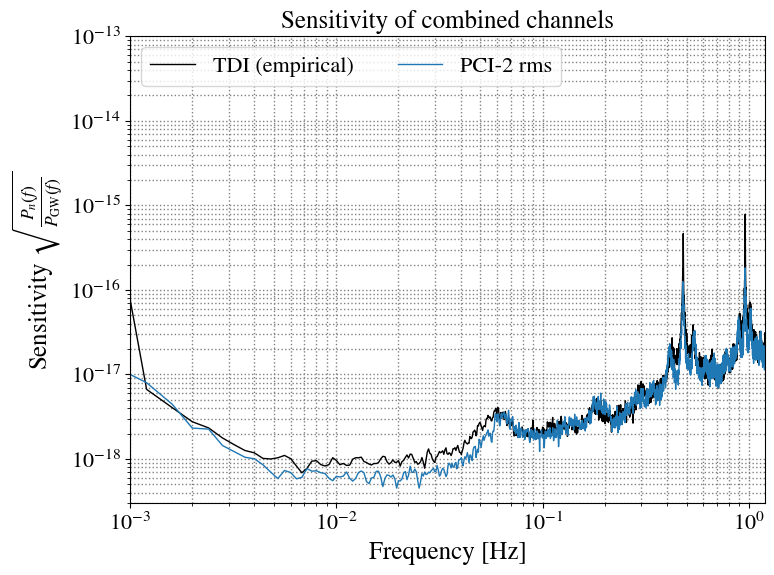

In [36]:
plotting.plotconfig(lbsize=18, lgsize=16)
_, axes = plt.subplots(1, 1, figsize=(8, 6))
axes.loglog(freqs, np.sqrt(mean_tdi2*ns/fs), 
            linewidth=1, label=r'TDI (empirical)',
            color='black')
for j in range(len(pci_sens_list)):
    #print(j)
    axes.loglog(pci_sens_list[j][1][0], np.sqrt(pci_sens_list[j][1][1]*ns/fs), 
                linewidth=1, label=pci_sens_list[j][0], rasterized=True)
axes.legend(loc='upper left', ncol=2)
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"Sensitivity $\sqrt{\frac{P_{n}(f)}{P_{\mathrm{GW}}(f)}}$")
axes.set_xlim([1e-3, 1.2])
axes.set_ylim([3e-19, 1e-13])
axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
axes.set_title("Sensitivity of combined channels")
plt.show()

In [37]:
pci_sens_list = []
#pci_sens_list += [
#    ["PCI-"+str(j)+" std", estimate_sensitivity(pca_list[j],y_full[:ns, :].T, y_gw[0:ns, :].T, n_channels=6, joint=True, welch_kwargs=welch_kwargs)] 
#     for j in range(3)]
pci_sens_list += [
    ["PCI-"+str(j)+" rms", estimate_sensitivity(pca_list_rs[j],y_full[:ns, :].T, y_gw[0:ns, :].T, n_channels=6, joint=True, welch_kwargs=welch_kwargs)] 
     for j in range(3)]




[0.0000e+00 4.0000e-04 8.0000e-04 ... 1.9992e+00 1.9996e+00 2.0000e+00] [[[ 4.84504860e-43+0.00000000e+00j  1.33466209e-42+0.00000000e+00j
    1.30176399e-43+0.00000000e+00j  3.06352278e-44+0.00000000e+00j
   -1.18309448e-43+0.00000000e+00j -1.55589208e-43+0.00000000e+00j]
  [ 1.33466209e-42-0.00000000e+00j  5.31410594e-42+0.00000000e+00j
    3.75817382e-43+0.00000000e+00j -3.11328100e-44+0.00000000e+00j
   -5.62303953e-43+0.00000000e+00j -6.58076376e-43+0.00000000e+00j]
  [ 1.30176399e-43-0.00000000e+00j  3.75817382e-43-0.00000000e+00j
    9.48784747e-44+0.00000000e+00j  6.55071782e-45+0.00000000e+00j
   -5.22420521e-44+0.00000000e+00j -9.58931185e-46+0.00000000e+00j]
  [ 3.06352278e-44-0.00000000e+00j -3.11328100e-44-0.00000000e+00j
    6.55071782e-45-0.00000000e+00j  5.03161687e-44+0.00000000e+00j
    4.81208102e-44+0.00000000e+00j  2.64561189e-44+0.00000000e+00j]
  [-1.18309448e-43-0.00000000e+00j -5.62303953e-43-0.00000000e+00j
   -5.22420521e-44-0.00000000e+00j  4.81208102e-44-0.

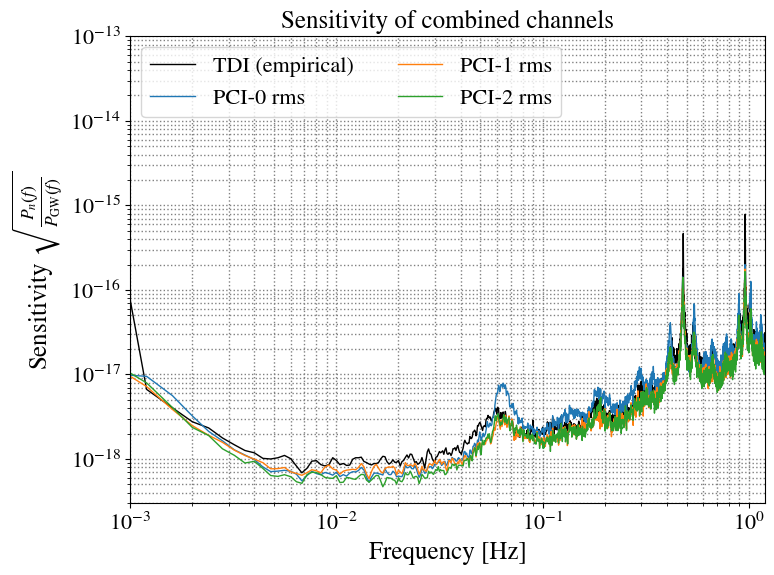

In [38]:
plotting.plotconfig(lbsize=18, lgsize=16)
_, axes = plt.subplots(1, 1, figsize=(8, 6))
axes.loglog(freqs, np.sqrt(mean_tdi2*ns/fs), 
            linewidth=1, label=r'TDI (empirical)',
            color='black')
for j in range(len(pci_sens_list)):
    #print(j)
    axes.loglog(pci_sens_list[j][1][0], np.sqrt(pci_sens_list[j][1][1]*ns/fs), 
                linewidth=1, label=pci_sens_list[j][0], rasterized=True)
axes.legend(loc='upper left', ncol=2)
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"Sensitivity $\sqrt{\frac{P_{n}(f)}{P_{\mathrm{GW}}(f)}}$")
axes.set_xlim([1e-3, 1.2])
axes.set_ylim([3e-19, 1e-13])
axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
axes.set_title("Sensitivity of combined channels")
plt.show()

Reconstructed single link sensitivities

In [39]:
pci_sens_list = []
#pci_sens_list += [
#    ["PCI-"+str(j)+" std", estimate_sensitivity(pca_list[j],y_full[:ns, :].T, y_gw[0:ns, :].T, n_channels=6, joint=True, welch_kwargs=welch_kwargs)] 
#     for j in range(3)]
pci_sens_list += [
    ["PCI-"+str(j)+" filtered", estimate_sensitivity(pca_list_rs[j],y_full[:ns, :].T, y_gw[0:ns, :].T, n_channels=6, joint=True, single_link=True, welch_kwargs=welch_kwargs)] 
     for j in range(3)]

single link data shape (6, 172710)
single link data shape (6, 172710)
[0.0000e+00 4.0000e-04 8.0000e-04 ... 1.9992e+00 1.9996e+00 2.0000e+00] [[[ 5.23548191e-49+0.00000000e+00j  1.00018585e-50+0.00000000e+00j
   -4.43790767e-48+0.00000000e+00j -5.23548155e-49+0.00000000e+00j
    2.39372980e-47+0.00000000e+00j  1.06119904e-50+0.00000000e+00j]
  [ 1.00018585e-50-0.00000000e+00j  2.07572112e-52+0.00000000e+00j
   -9.63943323e-50+0.00000000e+00j -1.00018577e-50+0.00000000e+00j
    4.47329625e-49+0.00000000e+00j  2.19360272e-52+0.00000000e+00j]
  [-4.43790767e-48-0.00000000e+00j -9.63943323e-50-0.00000000e+00j
    1.67304723e-46+0.00000000e+00j  4.43790696e-48+0.00000000e+00j
   -1.24395193e-46+0.00000000e+00j -1.01495377e-49+0.00000000e+00j]
  [-5.23548155e-49-0.00000000e+00j -1.00018577e-50-0.00000000e+00j
    4.43790696e-48-0.00000000e+00j  5.23548118e-49+0.00000000e+00j
   -2.39372968e-47+0.00000000e+00j -1.06119896e-50+0.00000000e+00j]
  [ 2.39372980e-47-0.00000000e+00j  4.47329625e-49

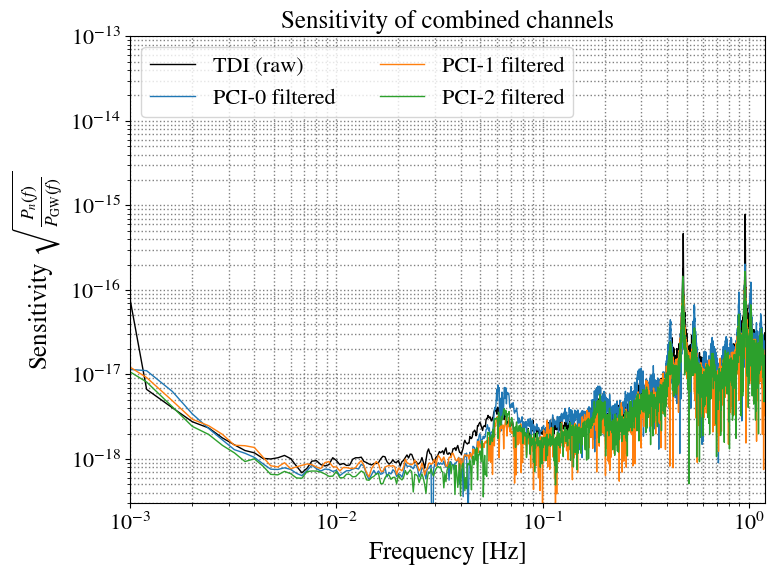

In [40]:
plotting.plotconfig(lbsize=18, lgsize=16)
_, axes = plt.subplots(1, 1, figsize=(8, 6))
axes.loglog(freqs, np.sqrt(mean_tdi2*ns/fs), 
            linewidth=1, label=r'TDI (raw)',
            color='black')
for j in range(len(pci_sens_list)):
    #print(j)
    axes.loglog(pci_sens_list[j][1][0], np.sqrt(pci_sens_list[j][1][1]*ns/fs), 
                linewidth=1, label=pci_sens_list[j][0], rasterized=True)
axes.legend(loc='upper left', ncol=2)
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"Sensitivity $\sqrt{\frac{P_{n}(f)}{P_{\mathrm{GW}}(f)}}$")
axes.set_xlim([1e-3, 1.2])
axes.set_ylim([3e-19, 1e-13])
axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
axes.set_title("Sensitivity of combined channels")
plt.show()

### PCI of single noise components

#### First we load the single noise data and generate the ys for those

In [49]:
# Get secondary noises
lockstr = 'locking_n1_12_baseline_noise_'

noises = ['test-mass', 'oms']

y_noise = {}

for nn in noises:
    noisepath = workdir + dtpath['noise']+ lockstr + nn + '_4Hz.h5'
    print(noisepath)
    
    data_noise = Data.from_instrument(noisepath)
    
    y_noise[nn] = build_data_vector(data_noise, skip=skip, dtype=np.float64)

You are using a measurement file in a version that might not be fully supported


/Users/ecastel2/Documents/research/GSFC/pci-inrep/simulations/2025-03-14_11h05_locking_n1_12_baseline_noise_test-mass_4Hz.h5


You are using a measurement file in a version that might not be fully supported


/Users/ecastel2/Documents/research/GSFC/pci-inrep/simulations/2025-03-14_11h05_locking_n1_12_baseline_noise_oms_4Hz.h5


In [50]:
y_noise

{'test-mass': array([[ 2.94542105e-20,  2.54838819e-21,  2.22385682e-20,
          1.78327467e-20,  4.18055912e-20, -9.65446150e-22],
        [ 3.64001947e-20,  8.61372645e-21, -1.90199151e-20,
         -1.35989950e-20,  7.73660184e-20,  4.21882958e-20],
        [ 4.45115147e-20,  6.76920905e-20,  4.32879629e-21,
          4.52870580e-20, -6.40992076e-20,  2.79610830e-20],
        ...,
        [-3.25773497e-19,  5.12629554e-19, -1.78603549e-19,
         -6.48988879e-20, -3.23099421e-19,  4.71607245e-19],
        [-3.22378122e-19,  5.45399356e-19, -8.89160226e-20,
         -6.09955975e-20, -2.83410041e-19,  5.54628725e-19],
        [-2.45264850e-19,  4.58884272e-19,  1.32691503e-20,
         -8.40906027e-20, -2.61729862e-19,  4.67637207e-19]]),
 'oms': array([[ 2.73354561e-19,  1.93581360e-19,  1.16587761e-20,
         -2.94017944e-19,  7.48987605e-21,  4.57661939e-19],
        [-4.57515257e-19, -1.48874736e-20,  1.25103339e-19,
          2.65764138e-21, -6.38228182e-20, -7.67679490e-19